# Montando Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importando as dependências

In [ ]:
import os
import shutil
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

# Definindo diretórios

In [ ]:
on_collab = True

dataset_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'ScientificResearch', 'Notebooks', 'TeethFeatureExtractor', 'teethes') if on_collab else os.path.join(os.getcwd(), 'teethes')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_validation_dir = os.path.join(dataset_dir, 'validation')
features_dir = os.path.join(dataset_dir, 'features')

# Criando classe extratora de features
A classe FeatureExtractor irá utilizar um modelo pronto disponibilizado pelo TensorFlow. Tem-se a arquitetura VGG-16 que é um rede neural convulacional que possui 16 camadas.
Mais informações sobre a arquitetura VGG-16 ver em: [VGG-16 Architecture](https://datagen.tech/guides/computer-vision/vgg16/)

## Sobre o modelo
- O modelo deve receber como entrada imagens de tamanho 224x224
- Como ponderação o modelo utiliza o peso imagenet, amplamente utilizado em modelos para classificação de imagens
- No FeatureExtractor estamos coletando a saída da camada FC1

In [ ]:
class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        img = img.resize((224, 224))
        img = img.convert('RGB')

        image_array = image.img_to_array(img)
        image_array = np.expand_dims(image_array, axis=0)
        image_array = preprocess_input(image_array)

        feature = self.model.predict(image_array)[0]

        return feature / np.linalg.norm(feature)

# Obtendo as features das imagens no datasete de treino
Para obter as features das imagens, itera-se sobre cada uma delas existente no dataset de treinamento chamando a função extract() da instância do feature_extractor

In [ ]:
feature_extractor = FeatureExtractor()

In [ ]:
dataset_train_images_dir = os.path.join(dataset_train_dir, 'images')

dataset_train_file_images = os.listdir(dataset_train_images_dir)

for image_name in tqdm(dataset_train_file_images):
    feature = feature_extractor.extract(img=Image.open(os.path.join(dataset_train_images_dir, str(image_name))))

    feature_path = os.path.join(features_dir, '{}.npy'.format(str(image_name).replace('.png','')))
    np.save(feature_path, feature)

  0%|          | 0/4999 [00:00<?, ?it/s]

1/1 [==============================] - 0s 225ms/step


## Colocando as features em um dataframe

In [ ]:
features = []
for file_name in tqdm(os.listdir(features_dir)):
  add_feature = np.load(os.path.join(features_dir, str(file_name)))
  add_feature = pd.DataFrame([add_feature])

  add_feature['image'] = file_name.replace('.npy','.png')

  features.append(add_feature)

features = pd.concat(features, axis=0)
features.to_csv(os.path.join(dataset_dir, 'feature_extraction.csv'), index=False)

  0%|          | 0/4999 [00:00<?, ?it/s]

## Obtendo as features já salvas

In [ ]:
loaded_features = pd.read_csv(os.path.join(dataset_dir, 'feature_extraction.csv'))

# Verificando a semelhança da imagem com o dataset disponível
1. Cópia do conteúdo existente no DataFrame loaded_features
2. Remoção da coluna image(que possui o nome do arquivo da imagem) do DataFrame, já que ela não possui informação relevante para o conteúdo das imagens
3. Obtenção apenas dos valores das features
4. Cálculo da distância euclidiana(responsável em indicar a similiridade entre duas imagens) entre as features das imagens do dataset de treino com as features da imagem fornecida como entrada

In [ ]:
def verify_similarity(image_name):
    dataset_manual_tests = os.path.join(dataset_dir, 'manual_tests')

    image_to_compare = Image.open(os.path.join(dataset_manual_tests, image_name))
    image_to_compare_features = feature_extractor.extract(image_to_compare)

    features_data = loaded_features.copy()
    features_data = features_data.drop(columns = ['image'])
    features_data = features_data.values

    euclidean_distance = np.linalg.norm(features_data - image_to_compare_features, axis=1)

    lower_distance_images_quantity = 30
    images_with_lowest_distance_ids = np.argsort(euclidean_distance)[:lower_distance_images_quantity]

    # Get only the lines with the images that have the given id
    more_similar_images = loaded_features.iloc[images_with_lowest_distance_ids,:]['image']
    scores = pd.DataFrame({
        'image': more_similar_images,
        'score': euclidean_distance[images_with_lowest_distance_ids]}
    )
    images_and_scores = scores.reset_index(drop=True)

    return images_and_scores, image_to_compare

## Visualizando as imagens semelhantes a passada pela entrada
Para verificar se uma imagem é semelhante a outra deve-se definir qual nível de semelhança deve ser considerado para classifica-la como "iguais". Como na aplicação atual busca-se imagens repetidas, normalmente a distância euclidiana deve ser bem baixa.

In [ ]:
def plot_images_with_similarity(image1, image2, similarity_score):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

  ax1.imshow(image1)
  ax1.set_title('Imagem to compare: ' + os.path.basename(image1.filename))
  ax1.axis('off')

  ax2.imshow(image2)
  ax2.set_title('Imagem in dataset: ' + os.path.basename(image2.filename))
  ax2.axis('off')

  fig.text(0.5, 0.05, 'Similaridade: {:.2f}%'.format(100 - similarity_score), ha='center', fontsize=12)

  plt.tight_layout()
  plt.show()

## Testes manuais feitos
1. Imagem com inversão horizontal
2. Imagem com inversão vertical
3. Imagem com rotação de 90 graus para a direita
4. Imagem com zoom

## Verificando similiraridade de uma imagem que está na base de dados

In [ ]:
original_image = '2001'

horizontal_revert_image = f'{original_image}_horizontal_revert'
vertical_revert_image = f'{original_image}_vertical_revert'
rotated_image = f'{original_image}_90_rotation'
zoomed_image = f'{original_image}_zoomed'

## 1
images_and_scores, image_to_compare = verify_similarity(f'{horizontal_revert_image}.png')
## 2
# images_and_scores, image_to_compare = verify_similarity(f'{vertical_revert_image}.png')
## 3
# images_and_scores, image_to_compare = verify_similarity(f'{rotated_image}.png')
## 4
# images_and_scores, image_to_compare = verify_similarity(f'{zoomed_image}.png')

1/1 [==============================] - 1s 696ms/step


## Mostrando apenas imagens consideradas similares

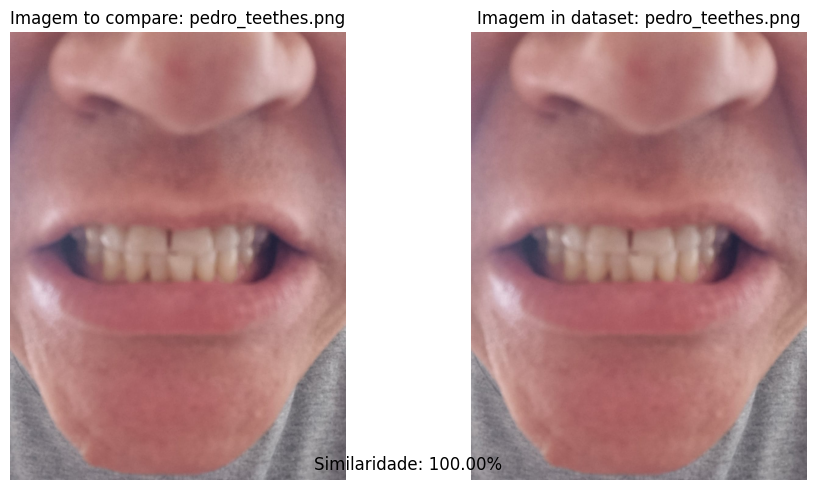

In [ ]:
minimum_euclidean_distance_to_be_equal = 0.3

images_and_scores = images_and_scores.sort_values(by=['score'])

found_similiar = False
for i in range(len(images_and_scores)):
    score = images_and_scores['score'][i]
    if score < minimum_euclidean_distance_to_be_equal:
      plot_images_with_similarity(image_to_compare, Image.open(os.path.join(dataset_train_dir, 'images', images_and_scores['image'][i]).replace('.jpg','')), score)
      found_similiar = True

if found_similiar == False:
  print("There is no similar image in our database")


## Mostrando todas as imagens com maior similaridade

In [ ]:
minimum_euclidean_distance_to_be_equal = 0.3

images_and_scores = images_and_scores.sort_values(by=['score'])

for i in range(len(images_and_scores)):
    score = images_and_scores['score'][i]
    plot_images_with_similarity(image_to_compare, Image.open(os.path.join(dataset_train_dir, 'images', images_and_scores['image'][i]).replace('.jpg','')), score)


## Removendo da base de dados imagem adicionada

In [ ]:
original_image = 'pedro_teethes'

In [ ]:
feature_extraction_csv_path = os.path.join(dataset_dir, 'feature_extraction.csv')
feature_extraction_test_csv_path = os.path.join(dataset_dir, 'feature_extraction_test.csv')

image_to_remove_train_path = os.path.join(dataset_dir, 'train', 'images', f'{original_image}.png')
image_to_remove_features_path = os.path.join(dataset_dir, 'features', f'{original_image}.npy')

if os.path.exists(feature_extraction_test_csv_path):
  print('Remove feature_extraction_test already existing and copy the original')
  os.remove(feature_extraction_test_csv_path)

shutil.copyfile(feature_extraction_csv_path, feature_extraction_test_csv_path)

if os.path.exists(image_to_remove_train_path):
  print('Image deleted with success')
  os.remove(image_to_remove_train_path)

if os.path.exists(image_to_remove_features_path):
  print('Feature deleted with success')
  os.remove(image_to_remove_features_path)

Remove feature_extraction_test already existing and copy the original
Image deleted with success
Feature deleted with success


## Fazendo o mesmo processo da imagem anterior mas com a nova imagem

## Adicionando a nova imagem a base de dados

In [ ]:
manual_tests_dir = os.path.join(dataset_dir, 'manual_tests')
manual_tests_file_images = os.listdir(manual_tests_dir)

# dataset_train_images_dir = os.path.join(dataset_train_dir, 'images')

# dataset_train_file_images = os.listdir(dataset_train_images_dir)

for image_name in tqdm(manual_tests_file_images):
  if image_name == f'{original_image}.png':
    new_image_to_add = Image.open(os.path.join(manual_tests_dir, str(image_name)))
    feature = feature_extractor.extract(img=new_image_to_add)

    feature_path = os.path.join(features_dir, '{}.npy'.format(str(image_name).replace('.png','')))
    np.save(feature_path, feature)

    new_image_to_add.save(os.path.join(dataset_train_dir, 'images', f'{original_image}.png'))


  0%|          | 0/8 [00:00<?, ?it/s]

1/1 [==============================] - 1s 782ms/step


In [ ]:
features = []
for file_name in tqdm(os.listdir(features_dir)):
  if file_name == f'{original_image}.npy':
    add_feature = np.load(os.path.join(features_dir, str(file_name)))
    add_feature = pd.DataFrame([add_feature])

    add_feature['image'] = file_name.replace('.npy','.png')

    features.append(add_feature)

features = pd.concat(features, axis=0)
features.to_csv(os.path.join(dataset_dir, 'feature_extraction_test.csv'), index=False, mode='a')

  0%|          | 0/5000 [00:00<?, ?it/s]

## Carregando as features da nova imagem

In [ ]:
loaded_features = pd.read_csv(os.path.join(dataset_dir, 'feature_extraction_test.csv'))

In [ ]:
images_and_scores, image_to_compare = verify_similarity(f'{original_image}.png')

1/1 [==============================] - 1s 728ms/step
